**This machine learning pipeine will be exploring whether weather, light, and road conditions – that increase the amount of information available about the situation – can increase the accuracy of predicting the severity of an accident.  **


In [9]:
# Libraries 
import pandas as pd
import numpy as np
import types
from botocore.client import Config
import ibm_boto3
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#from sklearn import preprocessing
import seaborn as sns
#from sklearn import ensemble, tree, linear_model
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt


In [7]:
pd.set_option('display.max_columns', 70) # Since we're dealing with moderately sized dataframe,
pd.set_option('display.max_rows', 13)# max 13 columns and rows will be shown


In [10]:
def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share the notebook.
client_6ab0b7b0bc0342f7ab46070093255cee = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='V4xCxkj8d6fZ9OF7_dT6lDnw0yR9F_WD5IyCegQjs18A',
    ibm_auth_endpoint="https://iam.cloud.ibm.com/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3.eu-geo.objectstorage.service.networklayer.com')

body = client_6ab0b7b0bc0342f7ab46070093255cee.get_object(Bucket='firstproject-donotdelete-pr-pzadqfsrf0bvat',Key='Kaagle_Upload.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df = pd.read_csv(body)
df.head()


/opt/conda/envs/Python36/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,1st_point_of_impact,was_vehicle_left_hand_drive?,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_(cc),propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile,NUmber_of_Casualities_unique_to_accident_index,No_of_Vehicles_involved_unique_to_accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_(district),local_authority_(highway),1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
0,201506E098757,2,9,0,18,0,8,0,0,0,0,3,1,6,1,45,7,1794,1,11,-1,1,-1,1,2,384980.0,394830.0,-2.227629,53.450014,6,3,2,1,42250,2,1899-12-30 12:56:00,102,E08000003,5,0,6,30,3,4,6,0,0,0,1,1,1,0,0,1,2,E01005288,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,201506E098766,1,9,0,9,0,8,0,0,0,0,4,1,6,2,25,5,1582,2,1,-1,-1,-1,1,2,383870.0,394420.0,-2.244322,53.446296,6,3,2,1,14/03/2015,7,1899-12-30 15:55:00,102,E08000003,3,5103,3,40,6,2,5,0,0,5,1,1,1,0,0,1,1,E01005178,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,201506E098766,2,9,0,18,0,8,0,0,0,0,1,1,6,1,51,8,-1,-1,-1,-1,1,-1,1,2,383870.0,394420.0,-2.244322,53.446296,6,3,2,1,14/03/2015,7,1899-12-30 15:55:00,102,E08000003,3,5103,3,40,6,2,5,0,0,5,1,1,1,0,0,1,1,E01005178,1.0,1.0,1.0,51.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,3.0
3,201506E098777,1,20,0,4,0,0,0,0,0,0,1,1,1,1,50,8,4462,2,1,-1,1,-1,1,1,386710.0,395700.0,-2.201617,53.457881,6,3,1,1,42311,4,1899-12-30 10:15:00,102,E08000003,3,6,6,30,0,-1,-1,0,0,4,1,1,1,0,0,1,1,E01005232,1.0,3.0,2.0,34.0,6.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
4,201506E098780,1,9,0,15,0,1,0,0,0,0,4,1,6,1,27,6,1598,2,-1,-1,1,-1,1,2,384280.0,395200.0,-2.238188,53.453319,6,3,2,1,42158,6,1899-12-30 08:03:00,102,E08000003,5,0,6,30,3,4,6,0,0,0,1,1,1,0,0,1,2,E01005242,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:

df=df.dropna() # The dataset is huge, therefore, dropping any rows with missing values is fine
df.head()
df.isnull().sum().sum()

# First I select variables based on prefrence, then for df2 I add weather related conditions of:
#'road_surface_conditions','light_conditions','weather_conditions'
#Feel free to mix these variables up
df2 = df[['special_conditions_at_site','pedestrian_movement','road_surface_conditions','light_conditions','weather_conditions','age_of_vehicle','sex_of_driver','age_of_driver','junction_location', 'junction_detail','junction_control','did_police_officer_attend_scene_of_accident','accident_severity','day_of_week']]
df1 = df[['special_conditions_at_site','pedestrian_movement','age_of_vehicle','sex_of_driver','age_of_driver','junction_location','junction_detail','junction_control','did_police_officer_attend_scene_of_accident','day_of_week','accident_severity']]


df1.replace(-1, np.nan, inplace=True) # -1 should be imputed to NaN to be recognized as missing in the next row
df1=df1.dropna() # I drop all the rows with missing data once again
df1.shape

df2.replace(-1, np.nan, inplace=True) # Same as previously 
df2=df2.dropna()
df2.shape


,accident_index,vehicle_reference,vehicle_type,towing_and_articulation,vehicle_manoeuvre,vehicle_location-restricted_lane,junction_location,skidding_and_overturning,hit_object_in_carriageway,vehicle_leaving_carriageway,hit_object_off_carriageway,1st_point_of_impact,was_vehicle_left_hand_drive?,journey_purpose_of_driver,sex_of_driver,age_of_driver,age_band_of_driver,engine_capacity_(cc),propulsion_code,age_of_vehicle,driver_imd_decile,driver_home_area_type,vehicle_imd_decile,NUmber_of_Casualities_unique_to_accident_index,No_of_Vehicles_involved_unique_to_accident_index,location_easting_osgr,location_northing_osgr,longitude,latitude,police_force,accident_severity,number_of_vehicles,number_of_casualties,date,day_of_week,time,local_authority_(district),local_authority_(highway),1st_road_class,1st_road_number,road_type,speed_limit,junction_detail,junction_control,2nd_road_class,2nd_road_number,pedestrian_crossing-human_control,pedestrian_crossing-physical_facilities,light_conditions,weather_conditions,road_surface_conditions,special_conditions_at_site,carriageway_hazards,urban_or_rural_area,did_police_officer_attend_scene_of_accident,lsoa_of_accident_location,casualty_reference,casualty_class,sex_of_casualty,age_of_casualty,age_band_of_casualty,casualty_severity,pedestrian_location,pedestrian_movement,car_passenger,bus_or_coach_passenger,pedestrian_road_maintenance_worker,casualty_type,casualty_home_area_type,casualty_imd_decile
2,201506E098766,2,9,0,18,0,8,0,0,0,0,1,1,6,1,51,8,-1,-1,-1,-1,1,-1,1,2,383870.0,394420.0,-2.244322,53.446296,6,3,2,1,14/03/2015,7,1899-12-30 15:55:00,102,E08000003,3,5103,3,40,6,2,5,0,0,5,1,1,1,0,0,1,1,E01005178,1.0,1.0,1.0,51.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,9.0,1.0,3.0
3,201506E098777,1,20,0,4,0,0,0,0,0,0,1,1,1,1,50,8,4462,2,1,-1,1,-1,1,1,386710.0,395700.0,-2.201617,53.457881,6,3,1,1,42311,4,1899-12-30 10:15:00,102,E08000003,3,6,6,30,0,-1,-1,0,0,4,1,1,1,0,0,1,1,E01005232,1.0,3.0,2.0,34.0,6.0,3.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
5,201506E098780,2,1,0,9,0,5,0,0,0,0,1,1,6,1,46,8,-1,-1,-1,-1,1,-1,1,2,384280.0,395200.0,-2.238188,53.453319,6,3,2,1,42158,6,1899-12-30 08:03:00,102,E08000003,5,0,6,30,3,4,6,0,0,0,1,1,1,0,0,1,2,E01005242,1.0,1.0,1.0,46.0,8.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,2.0
6,201506E098792,1,3,0,4,0,2,0,0,0,0,1,1,1,2,27,6,50,1,8,-1,1,-1,1,2,383870.0,393730.0,-2.244286,53.440094,6,3,2,1,19/03/2015,5,1899-12-30 20:35:00,102,E08000003,3,5103,3,40,6,2,5,0,0,5,7,1,1,0,0,1,1,E01005279,1.0,1.0,2.0,27.0,6.0,3.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,3.0
8,201506E098804,1,9,0,14,0,1,0,0,0,0,4,1,6,1,24,5,1398,1,1,-1,1,-1,1,1,385110.0,395540.0,-2.225706,53.456400,6,3,1,1,19/03/2015,5,1899-12-30 17:15:00,102,E08000003,4,5117,3,30,3,2,6,0,0,5,1,1,1,0,0,1,1,E01005284,1.0,3.0,1.0,12.0,3.0,3.0,1.0,2.0,0.0,0.0,0.0,0.0,1.0,2.0


0

/opt/conda/envs/Python36/lib/python3.6/site-packages/pandas/core/frame.py:4042: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  method=method)


(68210, 11)

(68121, 14)

In [12]:
# Here I took a subset of features from the previous cell. This is so I could narrow it more down / 
# This can be considered redundant, but was mostly part of the workflow when looking at different variables
df1 = df1[['special_conditions_at_site','pedestrian_movement','age_of_vehicle','sex_of_driver','age_of_driver','junction_location','junction_detail',
           'junction_control','day_of_week',
           'accident_severity']]

df2 = df2[['special_conditions_at_site','pedestrian_movement','road_surface_conditions','light_conditions','weather_conditions','age_of_vehicle','sex_of_driver','age_of_driver',
          'junction_location', 'junction_detail','junction_control',
          'accident_severity','day_of_week']]

df1.shape
df2.shape

(68210, 10)

(68121, 13)

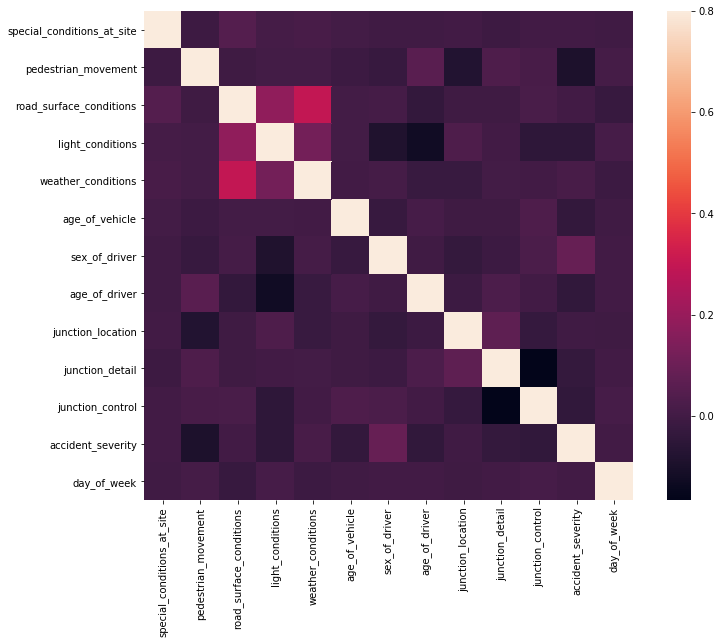

In [13]:
import matplotlib.pyplot as plt
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True)

#ax = sns.pairplot(df, size)
plt.show()


**The next step was to plot a Pearson correlation matrix to identify the amount of linear relationship be-tween variables in order to gain insight into dataand to determine whether linear based algorithms aresuitable. The matrix is color-coded - a value of one is represented by beige and shows a completely positive linear correlation. Dark purple represents a zero that suggests no linear correlation. As seen by the graph, there no linear relationships present, besides between the added features of weather condition, road surface,and light condition.This makes sense, as weather-, road-, and light conditions are dependent on each other. When it is raining, one can presume that the road condition atthe same time is also wet. Absence of other linear relationships can be explained by the fact that almost everything is a categorical variable. Even the weather related conditions barely achieve 0.4 on the Pearson correlation as they are nominal features as well.
Hence there is no justification and indication touse predictive models based on linearity** 


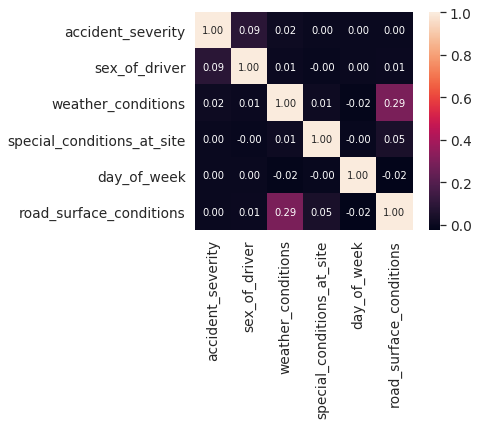

In [14]:
#cols2 = ['junction_detail','light_conditions','weather_conditions','casualty_type','day_of_week','junction_control','road_surface_conditions','casualty_severity']

k = 6 #number of variables for heatmap
cols = corrmat.nlargest(k, 'accident_severity')['accident_severity'].index
cm = np.corrcoef(df2[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

In [15]:
df2.head()

,special_conditions_at_site,pedestrian_movement,road_surface_conditions,light_conditions,weather_conditions,age_of_vehicle,sex_of_driver,age_of_driver,junction_location,junction_detail,junction_control,accident_severity,day_of_week
6,0.0,0.0,1.0,7,1,8.0,2.0,27.0,2.0,6.0,2.0,3,5
8,0.0,2.0,1.0,1,1,1.0,1.0,24.0,1.0,3.0,2.0,3,5
14,0.0,0.0,1.0,1,1,1.0,2.0,23.0,8.0,6.0,4.0,3,4
25,0.0,0.0,1.0,1,1,8.0,2.0,48.0,8.0,3.0,4.0,3,7
26,0.0,3.0,1.0,1,1,7.0,2.0,47.0,8.0,3.0,4.0,3,5


**In the cell below, one can hot encode the categorical variables. However, I noticed that the performance alteration was miniscule.**

In [17]:
# cols_with = ['junction_location','junction_detail','light_conditions','weather_conditions','day_of_week','junction_control','road_surface_conditions']
# cols_without = ['junction_location','junction_detail','day_of_week','junction_control']
# import seaborn as sns
# def one_hot(df, cols):
#     for each in cols:
#         dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
#         df = pd.concat([df, dummies],axis=1)
#     df = df.drop(cols, axis=1)
#     return df  %%!
# df2 = one_hot(df2,cols_with)
# df1 = one_hot(df1,cols_without)


**The next step was to normalize the only features that were not categorical: age of the driver and age of the car. 
  Normalization involves taking the logarithm of the given features. 
  This is done to because high values for certain variables computationally skew results more in favour of that variable, than their actual contribution. 
  In this case, age of the driver for example has values ranging from 18-88. When the majority of other categorical variables are binary or limited within 1-8 categories. **

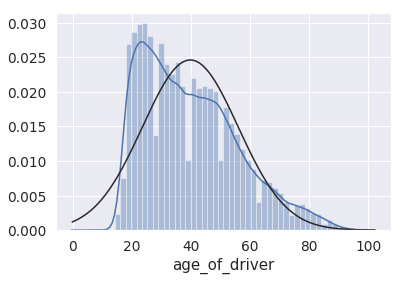

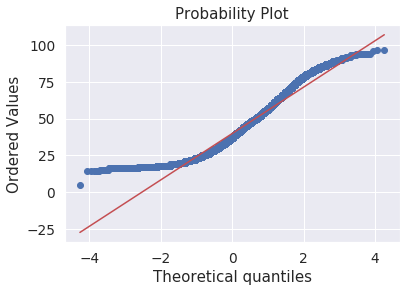

In [19]:
from scipy.stats import norm
from scipy import stats
#histogram and normal probability plot
sns.distplot(df1['age_of_driver'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['age_of_driver'], plot=plt)
plt.show()

**In this case, age of the driver and age of the vehicle were the only variables with a high numerical variance, and therefore logarithms were taken of both variables. Furthermore, taking the logarithm of both the age of the driver and age of the vehicle improved the fit by altering the scale, and making the variables more "normally" distributed.**


In [20]:
df2['age_of_driver'] = np.log1p(df2['age_of_driver']) 
df2['age_of_vehicle'] = np.log1p(df2['age_of_vehicle'])# standardise the feature

df1['age_of_driver'] = np.log1p(df1['age_of_driver']) 
df1['age_of_vehicle'] = np.log1p(df1['age_of_vehicle'])

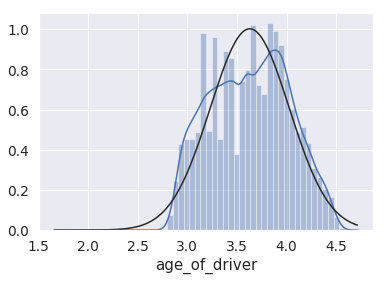

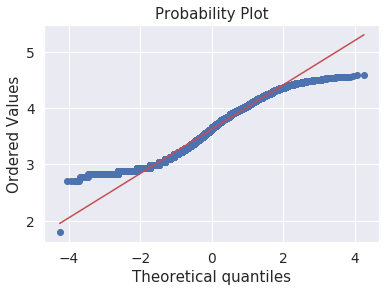

In [21]:
sns.distplot(df1['age_of_driver'], fit=norm);
fig = plt.figure()
res = stats.probplot(df1['age_of_driver'], plot=plt)
plt.show()

**After taking the log, one can notice that the values range from approximately 2.5 to 4.5. This increases the performance of machine learning algorithms, as the numerical values do not have disproportionate amounts of computing value compared to all the other categorical variables.
**

In [22]:
df2

,special_conditions_at_site,pedestrian_movement,road_surface_conditions,light_conditions,weather_conditions,age_of_vehicle,sex_of_driver,age_of_driver,junction_location,junction_detail,junction_control,accident_severity,day_of_week
6,0.0,0.0,1.0,7,1,2.197225,2.0,3.332205,2.0,6.0,2.0,3,5
8,0.0,2.0,1.0,1,1,0.693147,1.0,3.218876,1.0,3.0,2.0,3,5
14,0.0,0.0,1.0,1,1,0.693147,2.0,3.178054,8.0,6.0,4.0,3,4
25,0.0,0.0,1.0,1,1,2.197225,2.0,3.891820,8.0,3.0,4.0,3,7
26,0.0,3.0,1.0,1,1,2.079442,2.0,3.871201,8.0,3.0,4.0,3,5
28,0.0,0.0,1.0,1,1,2.079442,1.0,3.737670,8.0,6.0,4.0,3,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...
257628,0.0,0.0,1.0,1,1,2.564949,1.0,4.430817,8.0,3.0,4.0,1,4
257629,0.0,0.0,1.0,1,1,2.197225,2.0,3.931826,8.0,3.0,4.0,1,4
257639,0.0,0.0,1.0,1,1,1.945910,1.0,3.218876,1.0,3.0,4.0,3,7


In [23]:
df1= df1[:15000] #keep 1500 to decrease running times
df2= df2[:15000] #keep 15000

Y = df2.accident_severity.values
Y1 = df1.accident_severity.values
Y

array([3, 3, 3, ..., 3, 3, 3])

In [26]:
cols = df2.shape[1]
X = df2.loc[:, df2.columns != 'accident_severity']
X1 = df1.loc[:, df1.columns != 'accident_severity']
X.columns

Index(['special_conditions_at_site', 'pedestrian_movement',
       'road_surface_conditions', 'light_conditions', 'weather_conditions',
       'age_of_vehicle', 'sex_of_driver', 'age_of_driver', 'junction_location',
       'junction_detail', 'junction_control', 'day_of_week'],
      dtype='object')

In [25]:
X.shape
X1.shape

(15000, 12)

(15000, 9)

**Train machine learning algorithms without weather related data included**

In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

X_train1, X_test1,Y_train1,Y_test1 = train_test_split(X1, Y1, test_size=0.33, random_state=99)
#Without weather
svc = SVC()
svc.fit(X_train1, Y_train1)
Y_pred = svc.predict(X_test1)
acc_svc1 = round(svc.score(X_test1, Y_test1) * 100, 2)
acc_svc1

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train1, Y_train1)
Y_pred = knn.predict(X_test1)
acc_knn1 = round(knn.score(X_test1, Y_test1) * 100, 2)
acc_knn1


# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train1, Y_train1)
Y_pred = logreg.predict(X_test1)
acc_log1 = round(logreg.score(X_train1, Y_train1) * 100, 2)
acc_log1


# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train1, Y_train1)
Y_pred = gaussian.predict(X_test1)
acc_gaussian1 = round(gaussian.score(X_test1, Y_test1) * 100, 2)
acc_gaussian1

# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train1, Y_train1)
Y_pred = perceptron.predict(X_test1)
acc_perceptron1 = round(perceptron.score(X_test1, Y_test1) * 100, 2)
acc_perceptron1

# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train1, Y_train1)
Y_pred = linear_svc.predict(X_test1)
acc_linear_svc1 = round(linear_svc.score(X_test1, Y_test1) * 100, 2)
acc_linear_svc1

# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train1, Y_train1)
Y_pred = sgd.predict(X_test1)
acc_sgd1 = round(sgd.score(X_test1, Y_test1) * 100, 2)
acc_sgd1

# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train1, Y_train1)
Y_pred = decision_tree.predict(X_test1)
acc_decision_tree1 = round(decision_tree.score(X_test1, Y_test1) * 100, 2)
acc_decision_tree1

# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train1, Y_train1)
Y_pred = random_forest.predict(X_test1)
random_forest.score(X_train1, Y_train1)
acc_random_forest1 = round(random_forest.score(X_test1, Y_test1) * 100, 2)
acc_random_forest1

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

92.06

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

90.4

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

92.47

GaussianNB(priors=None, var_smoothing=1e-09)

90.0

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

92.0

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

92.06

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

92.06

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

86.87

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.9941293532338309

92.2

In [28]:
# Same with weather related data
# Support Vector Machines
X_train, X_test,Y_train,Y_test = train_test_split(X, Y, test_size=0.33, random_state=99)
#with weather condition

svc = SVC()
svc.fit(X_train, Y_train)
Y_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_test, Y_test) * 100, 2)
acc_svc
#KNN

knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, Y_train)
Y_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_test, Y_test) * 100, 2)
acc_knn

# Logistic Regression
logreg = LogisticRegression()
logreg.fit(X_train, Y_train)
Y_pred = logreg.predict(X_test)
acc_log = round(logreg.score(X_train, Y_train) * 100, 2)
acc_log

# Gaussian Naive Bayes

gaussian = GaussianNB()
gaussian.fit(X_train, Y_train)
Y_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_test, Y_test) * 100, 2)
acc_gaussian

# Perceptron

perceptron = Perceptron()
perceptron.fit(X_train, Y_train)
Y_pred = perceptron.predict(X_test)
acc_perceptron = round(perceptron.score(X_test, Y_test) * 100, 2)
acc_perceptron

# Linear SVC

linear_svc = LinearSVC()
linear_svc.fit(X_train, Y_train)
Y_pred = linear_svc.predict(X_test)
acc_linear_svc = round(linear_svc.score(X_test, Y_test) * 100, 2)
acc_linear_svc

# Stochastic Gradient Descent

sgd = SGDClassifier()
sgd.fit(X_train, Y_train)
Y_pred = sgd.predict(X_test)
acc_sgd = round(sgd.score(X_test, Y_test) * 100, 2)
acc_sgd

# Decision Tree

decision_tree = DecisionTreeClassifier()
decision_tree.fit(X_train, Y_train)
Y_pred = decision_tree.predict(X_test)
acc_decision_tree = round(decision_tree.score(X_test, Y_test) * 100, 2)
acc_decision_tree

# Random Forest

random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, Y_train)
Y_pred = random_forest.predict(X_test)
random_forest.score(X_train, Y_train)
acc_random_forest = round(random_forest.score(X_test, Y_test) * 100, 2)
acc_random_forest

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=False, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

92.12

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=3, p=2,
           weights='uniform')

90.2

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

92.47

GaussianNB(priors=None, var_smoothing=1e-09)

87.94

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in Perceptron in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


Perceptron(alpha=0.0001, class_weight=None, early_stopping=False, eta0=1.0,
      fit_intercept=True, max_iter=None, n_iter=None, n_iter_no_change=5,
      n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=None,
      validation_fraction=0.1, verbose=0, warm_start=False)

92.06

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

92.06

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/linear_model/stochastic_gradient.py:166: FutureWarning: max_iter and tol parameters have been added in SGDClassifier in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  FutureWarning)


SGDClassifier(alpha=0.0001, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

91.19

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

86.16

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

0.9977114427860696

92.59

In [29]:
print("Machine Learning algorithm scores without weather related conditions")
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc1, acc_knn1, acc_log1, 
              acc_random_forest1, acc_gaussian1, acc_perceptron1, 
              acc_sgd1, acc_linear_svc1, acc_decision_tree1]})
models.sort_values(by='Score', ascending=False)
print("Machine Learning algorithm scores with weather related conditions")
models = pd.DataFrame({
    'Model': ['Support Vector Machines', 'KNN', 'Logistic Regression', 
              'Random Forest', 'Naive Bayes', 'Perceptron', 
              'Stochastic Gradient Decent', 'Linear SVC', 
              'Decision Tree'],
    'Score': [acc_svc, acc_knn, acc_log, 
              acc_random_forest, acc_gaussian, acc_perceptron, 
              acc_sgd, acc_linear_svc, acc_decision_tree]})
models.sort_values(by='Score', ascending=False)

Machine Learning algorithm scores without weather related conditions


,Model,Score
2,Logistic Regression,92.47
3,Random Forest,92.20
0,Support Vector Machines,92.06
6,Stochastic Gradient Decent,92.06
7,Linear SVC,92.06
5,Perceptron,92.00
1,KNN,90.40
4,Naive Bayes,90.00
8,Decision Tree,86.87


Machine Learning algorithm scores with weather related conditions


,Model,Score
3,Random Forest,92.59
2,Logistic Regression,92.47
0,Support Vector Machines,92.12
5,Perceptron,92.06
7,Linear SVC,92.06
6,Stochastic Gradient Decent,91.19
1,KNN,90.20
4,Naive Bayes,87.94
8,Decision Tree,86.16


**The results indicated that adding weather-related features to a machine learning algorithm in predicting severity of an accident did not substantially change the accuracy of models. 
**
**The results indicate a high accuracy.
As this is multilabel classification, the accuracy measure in this case computes the amount of labels predicted that exactly match the corresponding set of labels.**

**However, we have to take into account the accuracy paradox as sometimes it may be desirable to select a model with a lower accuracy because it has a greater predictive power on the problem. In our dataset  there is a large class imbalance as most accidents are classified as mild(class 3) as shown in the graph below.**


In [30]:
# Confusion matrix with random forest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
x,y = df1.loc[:,df1.columns != 'accident_severity'], df1.loc[:,'accident_severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
y_test.value_counts()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=4, verbose=0, warm_start=False)

Confusion matrix: 
 [[   2    2   22]
 [   1   53  274]
 [   3   73 4070]]
Classification report: 
               precision    recall  f1-score   support

           1       0.33      0.08      0.12        26
           2       0.41      0.16      0.23       328
           3       0.93      0.98      0.96      4146

   micro avg       0.92      0.92      0.92      4500
   macro avg       0.56      0.41      0.44      4500
weighted avg       0.89      0.92      0.90      4500



3    4146
2     328
1      26
Name: accident_severity, dtype: int64

**A model can predict the value of the majority class for all predictions and yield a high accuracy although almost all of the predictions would concern the majority class; hence, yielding a very high accuracy. Precision-Recall is a useful measure of success of prediction when the classes are very imbalanced. Precision is a measure of result relevancy, while recall is a measure of how many truly relevant results are returned. Moreover, another metric is F1 score which is a measure of a test's accuracy. It considers both the precision p and the recall r of the test to compute the score and returns an compromise between precision and recall. **

**A clean and unambiguous way to present the prediction results of a classifier is to use a use a confusion matrix. On below is for without weather conditions and one below is with weather conditions included
**

In [31]:
# Confusion matrix with random forest
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
x,y = df2.loc[:,df2.columns != 'accident_severity'], df2.loc[:,'accident_severity']
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.3,random_state = 1)
rf = RandomForestClassifier(random_state = 4)
rf.fit(x_train,y_train)
y_pred = rf.predict(x_test)
cm = confusion_matrix(y_test,y_pred)
print('Confusion matrix: \n',cm)
print('Classification report: \n',classification_report(y_test,y_pred))
y_test.value_counts()

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=4, verbose=0, warm_start=False)

Confusion matrix: 
 [[   2    1   23]
 [   1   56  271]
 [   1   71 4074]]
Classification report: 
               precision    recall  f1-score   support

           1       0.50      0.08      0.13        26
           2       0.44      0.17      0.25       328
           3       0.93      0.98      0.96      4146

   micro avg       0.92      0.92      0.92      4500
   macro avg       0.62      0.41      0.45      4500
weighted avg       0.89      0.92      0.90      4500



3    4146
2     328
1      26
Name: accident_severity, dtype: int64

**The precision, recall, and F1 score are also at high levels of 0.89, 0.92, and 0.9 respectively - meaning that the classification is successful and the accuracy of the model is more or less 90\% when investigated on multiple metrics. **

**When taking into consideration the weather condition, the lighting condition, and road surface conditions the accuracy of machine learning models are as follows: **

sns.heatmap(cm,annot=True,fmt="d") 
plt.show()

**The results indicated that adding weather-related features to a machine learning algorithm in predicting severity of an accident did not change the accuracy of the model. When adding three features of light condition, weather condition, and the condition of the road surface, the measures of recall, precision, and f1-score remained unchanged. **

**When looking at the overall performance of all of the algorithms, there was an increase in accuracy between the data with weather conditions when compared to data without weather related conditions. Namely, random forest algorithm increased performance by 0.59%. The previous top performer when no weather related conditions were introduced, Logistic Regression, sustained the same level of accuracy. Hence, it was concluded to further scrutinize the recall, precision, and f1-score of random forest algorithm to see whether there was an actual change in prediction power. **
